Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [2]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    mean_squared_error, r2_score, silhouette_score
)


In [3]:
import warnings
warnings.filterwarnings("ignore")

Loading and Cleaning Data

In [4]:
df = pd.read_csv("Data/diabetes_dataset.csv")

In [5]:
cols_with_zero = ['glucose_fasting', 'glucose_postprandial', 'systolic_bp',
                   'diastolic_bp', 'insulin_level', 'bmi']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

ML-based Imputation with Domain Feature Selection

In [6]:
# Define the target columns you want to predict
target_cols = ['glucose_fasting', 'glucose_postprandial', 'systolic_bp',
               'diastolic_bp', 'insulin_level', 'bmi']

In [7]:
# Define domain-specific feature sets for each target
features_dict = {
    'glucose_fasting': [
        'age', 'bmi', 'insulin_level', 'physical_activity_minutes_per_week',
        'diet_score', 'sleep_hours_per_day', 'hypertension_history', 'cholesterol_total'
    ],
    'glucose_postprandial': [
        'glucose_fasting', 'insulin_level', 'bmi',
        'diet_score', 'physical_activity_minutes_per_week', 'sleep_hours_per_day'
    ],
    'systolic_bp': [
        'age', 'bmi', 'physical_activity_minutes_per_week', 'hypertension_history',
        'cardiovascular_history', 'cholesterol_total', 'diet_score'
    ],
    'diastolic_bp': [
        'age', 'bmi', 'physical_activity_minutes_per_week', 'hypertension_history',
        'cardiovascular_history', 'cholesterol_total'
    ],
    'insulin_level': [
        'glucose_fasting', 'glucose_postprandial', 'bmi',
        'diet_score', 'physical_activity_minutes_per_week', 'sleep_hours_per_day'
    ],
    'bmi': [
        'age', 'physical_activity_minutes_per_week', 'diet_score',
        'sleep_hours_per_day', 'income_level'
    ]
}


In [8]:
def predict_missing_values(df, target, features):
    """
    Trains a model for one target column and fills its missing values.
    """
    print(f"\n🔹 Predicting missing values for: {target}")

    known = df[df[target].notnull()]
    missing = df[df[target].isnull()]

    if missing.empty:
        print(f" No missing values for {target}")
        return df

    # Prepare data
    X = known[features].fillna(known[features].median())
    y = known[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train model
    model = RandomForestRegressor(random_state=42, n_estimators=200)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    print(f"   R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"   MAE: {mean_absolute_error(y_test, y_pred):.3f}")

    # Predict missing
    X_missing = missing[features].fillna(missing[features].median())
    df.loc[df[target].isnull(), target] = model.predict(X_missing)

    print(f" Missing values for {target} have been predicted and filled!")
    return df


In [9]:
# Loop through each target and call the function
for target in target_cols:
    features = features_dict[target]
    df = predict_missing_values(df, target, features)

print("\n All missing values have been predicted and filled successfully!")



🔹 Predicting missing values for: glucose_fasting
 No missing values for glucose_fasting

🔹 Predicting missing values for: glucose_postprandial
 No missing values for glucose_postprandial

🔹 Predicting missing values for: systolic_bp
 No missing values for systolic_bp

🔹 Predicting missing values for: diastolic_bp
 No missing values for diastolic_bp

🔹 Predicting missing values for: insulin_level
 No missing values for insulin_level

🔹 Predicting missing values for: bmi
 No missing values for bmi

 All missing values have been predicted and filled successfully!


Data Validation

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 100000 non-null  int64  
 1   gender                              100000 non-null  object 
 2   ethnicity                           100000 non-null  object 
 3   education_level                     100000 non-null  object 
 4   income_level                        100000 non-null  object 
 5   employment_status                   100000 non-null  object 
 6   smoking_status                      100000 non-null  object 
 7   alcohol_consumption_per_week        100000 non-null  int64  
 8   physical_activity_minutes_per_week  100000 non-null  int64  
 9   diet_score                          100000 non-null  float64
 10  sleep_hours_per_day                 100000 non-null  float64
 11  screen_time_hours_per_day  

In [11]:
df.describe()
df.isnull().sum()

age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
glucose_fasting                       0


Exploratory Data Analysis (EDA)

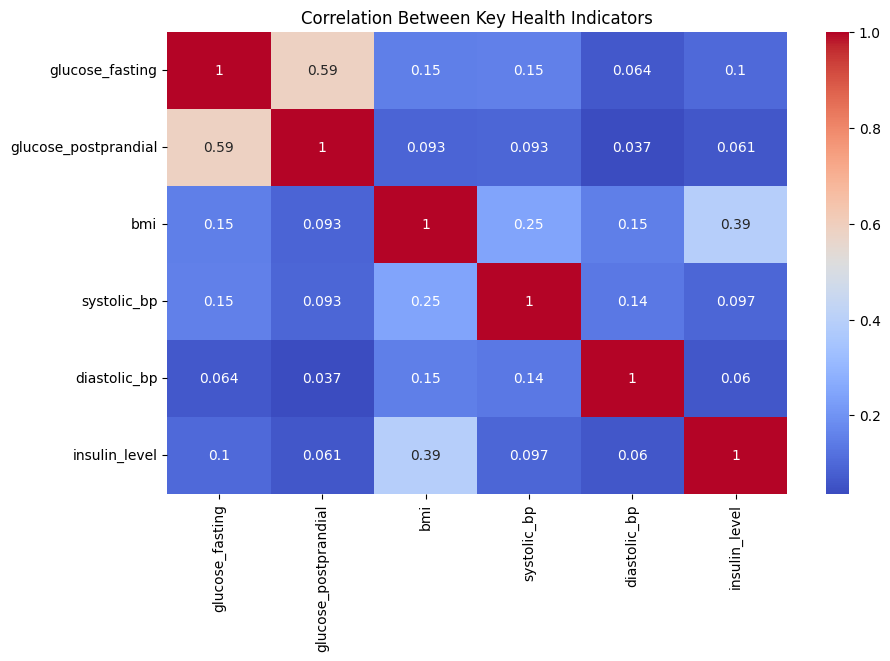

In [12]:
# Correlation heatmap
numeric_cols = ['glucose_fasting', 'glucose_postprandial', 'bmi', 
                'systolic_bp', 'diastolic_bp', 'insulin_level']
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Key Health Indicators")
plt.show()

Scaling Features

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])

print("Scaling complete. Shape:", X_scaled.shape)

Scaling complete. Shape: (100000, 6)


In [14]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance by 2 PCs:", pca.explained_variance_ratio_)


Explained variance by 2 PCs: [0.30997552 0.21969664]


In [15]:
df.shape

(100000, 31)

In [16]:
# Step 1: Use a smaller random sample for evaluation
sample_df = df.sample(n=2000, random_state=42)  # 2000 rows is more than enough
X_sample = scaler.fit_transform(sample_df[numeric_cols])

# Step 2: Try multiple k values efficiently
inertias = []
silhouettes = []
K = range(2, 7)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=100)
    labels = kmeans.fit_predict(X_sample)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_sample, labels))

Cluster Visualization and Interpretation

In [17]:
CHOSEN_K = 3
kmeans = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10, max_iter=100)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to df
df['Cluster'] = clusters

print(f" KMeans clustering done with k={CHOSEN_K}")

 KMeans clustering done with k=3


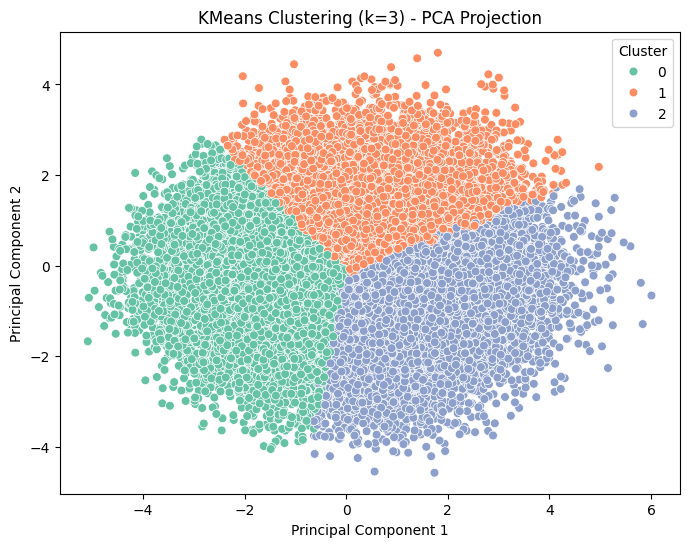

In [18]:
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=40)
plt.title(f'KMeans Clustering (k={CHOSEN_K}) - PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [19]:
print(" Average values per cluster:")
display(df.groupby('Cluster')[numeric_cols].mean().round(2))

 Average values per cluster:


,glucose_fasting,glucose_postprandial,bmi,systolic_bp,diastolic_bp,insulin_level
Cluster,,,,,,
0,99.86,135.29,24.07,110.49,73.61,7.34
1,120.60,183.56,24.30,114.06,73.80,6.90
2,114.70,165.26,28.68,123.63,78.50,13.17


** Insights & Conclusion**

After performing K-Means clustering on the cleaned and imputed diabetes dataset, the data grouped naturally into three distinct clusters based on health indicators such as glucose levels, BMI, blood pressure, and insulin.

**Cluster 0 – Balanced Profile**
- Moderate glucose and BMI values.
- Represents individuals with relatively healthy metabolic indicators.
- Likely to be *low-risk* for diabetes complications.

**Cluster 1 – Elevated Glucose Levels**
- High fasting and postprandial glucose.
- Slightly higher BMI compared to Cluster 0.
- Indicates *at-risk individuals* who may require early lifestyle or dietary interventions.

**Cluster 2 – High BMI & Insulin Resistance**
- Highest BMI, blood pressure, and insulin levels.
- Clear signs of *metabolic imbalance*.
- Represents *high-risk diabetic patients* who may already show insulin resistance patterns.

**Overall Observation**
- *Glucose and BMI* play the strongest roles in defining cluster boundaries.
- The PCA scatter plot confirms visible separation between groups, validating the clustering.
- This segmentation can help target medical guidance more effectively — focusing on prevention for moderate clusters and management for high-risk ones.

**Next Possible Extensions**
- Compare clusters with the `diagnosed_diabetes` column to check prediction alignment.
- Use models like DBSCAN or Hierarchical Clustering for validation.
- Visualize lifestyle factors (diet, physical activity) to study their influence on cluster formation.
